<a href="https://colab.research.google.com/github/mvfolino68/portfolio/blob/master/nmf_corpus_topic_modeling_CFPB/CFPB%20topic%20extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning

##What Exactly is AI and Machine Learning?
![alt text](https://s29093.pcdn.co/wp-content/uploads/2018/09/AI-Terminology-Header.png)

---




![alt text](https://neptune-int.com/machine-learning/img/learn-predict-act.png)

---




![alt text](https://www.consumerfinance.gov/static/img/logo_237x50.c7c2ba6c929f.png)

---


#Our Problem - Identify Common Topics in Customer Complaints to Consumer Financial Protection Bureau


---


#Our Solution - Use Non Negative Matrix Factorization and Natural Language Processing to Extract Repeated Topics

---



##Import Modules

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from time import time

import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

print(__doc__)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Automatically created module for IPython interactive environment


##Get the Data

###Import Data

In [0]:
df = pd.read_csv('https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD', encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##Pre Process and Explore the Data

###Function creation for preprocessing

In [0]:
#create word lemmetizer object
lemmatizer = WordNetLemmatizer() 

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. remove x, M, T
    3. Remove all stopwords
    4. remove any non alpha words
    5. Returns a list of the cleaned text
    """
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = [char for char in mess if char not in ['X']]
    

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc).lower()
    
    clean_words = [lemmatizer.lemmatize(word) for word in nopunc.split() if word.lower() not in ENGLISH_STOP_WORDS ]
    clean_words = [word for word in clean_words if word.lower().isalpha()]
    
    # Now just remove any stopwords
    words = [word for word in clean_words if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(words).lower().replace(' m t ', ' ')

###Pre Processing data

In [0]:
bank_name = 'M&T BANK CORPORATION'
df = df[pd.notnull(df['Consumer complaint narrative'].str.strip())]
df2 =df[df['Company'].str.contains(bank_name)].reset_index()
df2['Consumer complaint narrative clean'] = df2['Consumer complaint narrative'].apply(text_process)
df2.drop(columns=['index'])
df2.head()


,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Consumer complaint narrative clean
0,34405,03/13/2019,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,I purchased a condo on XX/XX/XXXX in XXXX XXXX...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,NaN,NaN,NaN,Consent provided,Web,03/14/2019,Closed with explanation,Yes,NaN,3179148,purchased condo ny late mortgage continued pay...
1,41058,03/05/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,i have a mortgage payment due by the XXXX othe...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,FL,NaN,Older American,Consent provided,Web,03/05/2019,Closed with explanation,Yes,NaN,3169543,mortgage payment make late payment work anymor...
2,41667,03/04/2019,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,My mortgage was initially a fixed rate mortgag...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,SC,NaN,NaN,Consent provided,Web,03/04/2019,Closed with non-monetary relief,Yes,NaN,3168442,mortgage initially fixed rate mortgage switche...
3,42502,03/03/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,My mortgage company M & T Bank has refused pay...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,AZ,853XX,NaN,Consent provided,Web,03/03/2019,Closed with explanation,Yes,NaN,3167681,mortgage company bank refused payment ran chec...
4,43671,03/01/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,According to my understanding of the Homeowner...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,TN,371XX,NaN,Consent provided,Web,03/01/2019,Closed with explanation,Yes,NaN,3166538,according understanding homeowner protection p...


In [0]:
import datetime as dt
df_group = df2[['Product','Complaint ID']].groupby(['Product']).count().reset_index().dropna()


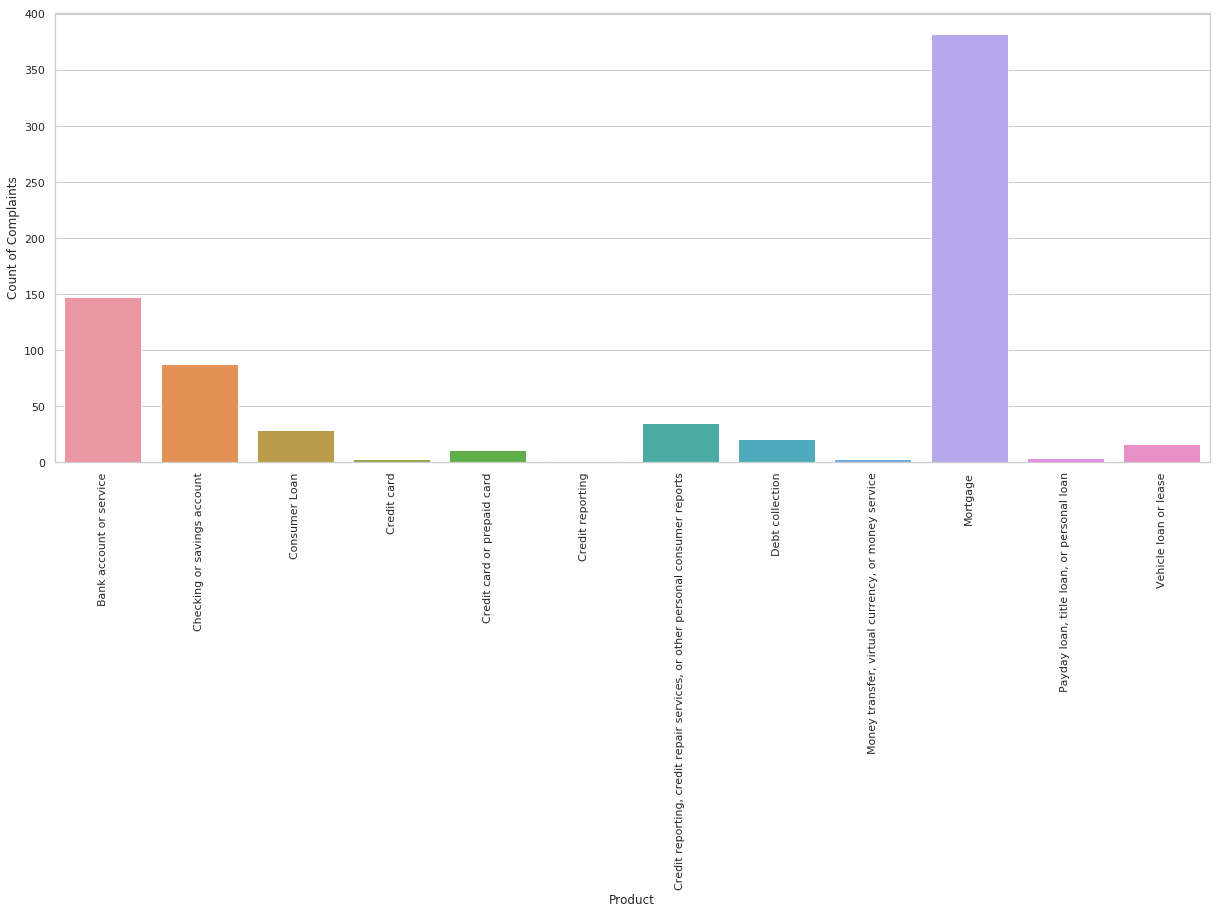

In [0]:
sns.set(style="whitegrid")
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20.7, 8.27)
ax = sns.barplot(x="Product", y="Complaint ID",  data=df_group)
ax.set(xlabel='Product', ylabel='Count of Complaints')
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

#Select Model and Apply Algorithm

##Use Term Frequency - Inverse Document Frequency to Vectorize Complaints and Factorize Resulting Matrix


In [0]:
n_samples = 741
n_features = 10000
n_components = 10

def print_top_words(model, feature_names, n_top_words, chunk_size=10):
    for topic_idx, topic in enumerate(model.components_):
        message = '-'*30 +'\n'
        message += f"Topic {topic_idx}\n"
        print(message)
        print([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]])
    print()
    
# get sample
text = df2['Consumer complaint narrative clean'].iloc[np.random.choice(df2.index,n_samples,replace=False)]

# get tfidf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, ngram_range=(1,3))
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(text)
t1 = time()
print(f"Time for Tfidf Vectorization: {t1-t0}s")

# nmf
print(f"Fitting NMF with {n_samples} samples and {n_components} components")
t0 = time()
nmf = NMF(n_components=n_components, alpha=.1, l1_ratio=.5).fit(tfidf)
t1 = time()
print(f"Finished fitting.  It took {t1-t0}s")
print()

Time for Tfidf Vectorization: 0.6574437618255615s
Fitting NMF with 741 samples and 10 components
Finished fitting.  It took 0.8939521312713623s



##Extract the topics

In [0]:
feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, feature_names, 20)

------------------------------
Topic 0

['loan', 'bank', 'modification', 'mortgage', 'home', 'foreclosure', 'loan modification', 'letter', 'year', 'payment', 'time', 'property', 'received', 'document', 'sale', 'request', 'house', 'process', 'sent', 'date']
------------------------------
Topic 1

['account', 'bank', 'check', 'money', 'told', 'called', 'branch', 'did', 'said', 'customer', 'letter', 'service', 'day', 'received', 'fund', 'sent', 'asked', 'time', 'deposit', 'went']
------------------------------
Topic 2

['payment', 'late', 'month', 'make', 'late fee', 'late payment', 'make payment', 'mortgage', 'payment payment', 'pay', 'mortgage payment', 'monthly', 'making', 'missed', 'fee', 'told', 'payment bank', 'payment late', 'paid', 'did']
------------------------------
Topic 3

['bonus', 'account', 'direct', 'opened', 'direct deposit', 'code', 'deposit', 'checking', 'checking account', 'promotion', 'promotional', 'offer', 'promo', 'met', 'promo code', 'opening', 'opened account', 